In [1]:
import gc
import torch


def refresh_cuda_memory():
    """
    Re-allocate all cuda memory to help alleviate fragmentation
    """
    # Run a full garbage collect first so any dangling tensors are released
    gc.collect()

    # Then move all tensors to the CPU
    locations = {}
    for obj in gc.get_objects():
        if not isinstance(obj, torch.Tensor):
            continue

        locations[obj] = obj.device
        obj.data = obj.data.cpu()
        if isinstance(obj, torch.nn.Parameter) and obj.grad is not None:
            obj.grad.data = obj.grad.cpu()

    # Now empty the cache to flush the allocator
    torch.cuda.empty_cache()

    # Finally move the tensors back to their associated GPUs
    for tensor, device in locations.items():
        tensor.data = tensor.to(device)
        if isinstance(tensor, torch.nn.Parameter) and tensor.grad is not None:
            tensor.grad.data = tensor.grad.to(device)
            
refresh_cuda_memory()

/home/neo/miniconda3/envs/cifar10-resnet/lib/python3.9/site-packages/torch/distributed/distributed_c10d.py:170: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


In [2]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2
from pathlib import Path
import glob
import time
from PIL import Image as PIMG

%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'


a = torch.cuda.memory_allocated(0)
print("torch.cuda.memory_allocated: ", a)
c = torch.cuda.memory_reserved(0)
print("torch.cuda.memory_reserved: ", c)

del a
del c
print(torch.cuda.memory_allocated())
torch.cuda.empty_cache()
torch.cuda.synchronize()
print(torch.cuda.memory_allocated())

refresh_cuda_memory()

PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb=128

torch.cuda.memory_allocated:  0
torch.cuda.memory_reserved:  0
0
0


/home/neo/miniconda3/envs/cifar10-resnet/lib/python3.9/site-packages/torch/distributed/distributed_c10d.py:170: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


In [3]:
a = torch.cuda.memory_allocated(0)
print("torch.cuda.memory_allocated: ", a)
c = torch.cuda.memory_reserved(0)
print("torch.cuda.memory_reserved: ", c)

del a
del c
print(torch.cuda.memory_allocated())
torch.cuda.empty_cache()
torch.cuda.synchronize()
print(torch.cuda.memory_allocated())

torch.cuda.memory_allocated:  0
torch.cuda.memory_reserved:  0
0
0


In [4]:
project_name='cifar10-resnet'

In [5]:
from torchvision.datasets.utils import download_url


# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
    
# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)
labels_g = torch.FloatTensor([])

Using downloaded and verified file: ./cifar10.tgz
['train', 'train2', 'train3', 'test']
['bird', 'ship', 'cat', 'truck', 'deer', 'horse', 'frog', 'airplane', 'automobile', 'dog']


In [6]:
# V2
tr_image_list = glob.glob('./data/cifar10/train/*/*.png')
vl_image_list = glob.glob('./data/cifar10/test/*/*.png')
print(len(tr_image_list))
print(len(vl_image_list))
#print(image_list)

50000
10000


In [7]:
# V2
# custom dataset class for albumentations library
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
class AlbumentationTrainImageDataset(Dataset):
    def __init__(self, image_list):
        self.image_list = image_list
#         self.aug = A.Compose({
#         A.CropAndPad(4, pad_mode=4, keep_size=False, sample_independently=True),
#         A.RandomCrop(32, 32, always_apply=True, p=1.0),
#         A.HorizontalFlip(p=0.5),
#         A.Cutout(num_holes=1, max_h_size=8, max_w_size=8, fill_value=0, always_apply=True, p=1.0),
#         A.Normalize(*stats), #(0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#         })
        self.CropPad = A.CropAndPad(4, pad_mode=4, keep_size=False, sample_independently=True)
        self.RandCrop = A.RandomCrop(32, 32, always_apply=True, p=1.0)
        self.flipLR = A.HorizontalFlip(p=0.5)
        self.cutOt = A.Compose({
            A.Cutout(num_holes=1, max_h_size=8, max_w_size=8, fill_value=0, always_apply=True, p=1.0),
            A.Normalize(*stats), #(0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        })         
         
    def __len__(self):
        return (len(self.image_list))
    
    def __getitem__(self, i):
        content_array = plt.imread(self.image_list[i])
#        print(type(content_array))
#         random_array = np.random.random_sample(content_array.shape) * 255
        content_array = content_array * 255
        content_array = content_array.astype(np.uint8)
        image = PIMG.fromarray(content_array).convert('RGB')
#         image = self.aug(image=np.array(image))['image']
        image1 = self.CropPad(image=np.array(image))['image']
        image2 = self.RandCrop(image=np.array(image1))['image']
        image3 = self.flipLR(image=np.array(image2))['image']
        image4 = self.cutOt(image=np.array(image3))['image']
        image5 = np.transpose(image4, (2, 0, 1)).astype(np.float32)
            
        return torch.tensor(image5, dtype=torch.float)
    
class AlbumentationValImageDataset(Dataset):
    def __init__(self, image_list):
        self.image_list = image_list
        self.aug = A.Normalize(*stats) #(0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
         
    def __len__(self):
        return (len(self.image_list))
    
    def __getitem__(self, i):
        content_array = plt.imread(self.image_list[i])
#         random_array = np.random.random_sample(content_array.shape) * 255
        content_array = content_array * 255
        content_array = content_array.astype(np.uint8)
        image = PIMG.fromarray(content_array).convert('RGB')
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
            
        return torch.tensor(image, dtype=torch.float)

In [8]:
batch_sz= 16 #400

In [9]:
# PyTorch datasets
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

train_ds = ImageFolder(data_dir+'/train', valid_tfms)
train_dl = DataLoader(train_ds, batch_sz, num_workers=3, pin_memory=True)

valid_ds = ImageFolder(data_dir+'/test', valid_tfms)
valid_dl = DataLoader(valid_ds, batch_sz, num_workers=3, pin_memory=True)

In [10]:
# V2
train_ds_Alb = AlbumentationTrainImageDataset(image_list=tr_image_list)
train_dl_Alb = DataLoader(train_ds_Alb, batch_sz,   shuffle=True)
#train_dl =     DataLoader(train_ds,     batch_size, shuffle=True, num_workers=3, pin_memory=True)
print("train_dl_Alb.len: ", len(train_dl_Alb))

val_ds_Alb = AlbumentationValImageDataset(image_list=vl_image_list)
val_dl_Alb = DataLoader(val_ds_Alb, batch_sz, shuffle=True)
print("val_dl_Alb.len: ", len(val_dl_Alb))

# for v_imgs, v_labels in enumerate(val_dl_Alb):
#     print(type(v_imgs))
#     print(type(v_labels))

train_dl_Alb.len:  3125
val_dl_Alb.len:  625


/home/neo/miniconda3/envs/cifar10-resnet/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:688: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


In [11]:
for idx, images in enumerate(val_dl_Alb):
    print("index: ", idx, "                images.shape: ", images.shape)

index:  0                 images.shape:  torch.Size([16, 3, 32, 32])
index:  1                 images.shape:  torch.Size([16, 3, 32, 32])
index:  2                 images.shape:  torch.Size([16, 3, 32, 32])
index:  3                 images.shape:  torch.Size([16, 3, 32, 32])
index:  4                 images.shape:  torch.Size([16, 3, 32, 32])
index:  5                 images.shape:  torch.Size([16, 3, 32, 32])
index:  6                 images.shape:  torch.Size([16, 3, 32, 32])
index:  7                 images.shape:  torch.Size([16, 3, 32, 32])
index:  8                 images.shape:  torch.Size([16, 3, 32, 32])
index:  9                 images.shape:  torch.Size([16, 3, 32, 32])
index:  10                 images.shape:  torch.Size([16, 3, 32, 32])
index:  11                 images.shape:  torch.Size([16, 3, 32, 32])
index:  12                 images.shape:  torch.Size([16, 3, 32, 32])
index:  13                 images.shape:  torch.Size([16, 3, 32, 32])
index:  14                 ima

index:  119                 images.shape:  torch.Size([16, 3, 32, 32])
index:  120                 images.shape:  torch.Size([16, 3, 32, 32])
index:  121                 images.shape:  torch.Size([16, 3, 32, 32])
index:  122                 images.shape:  torch.Size([16, 3, 32, 32])
index:  123                 images.shape:  torch.Size([16, 3, 32, 32])
index:  124                 images.shape:  torch.Size([16, 3, 32, 32])
index:  125                 images.shape:  torch.Size([16, 3, 32, 32])
index:  126                 images.shape:  torch.Size([16, 3, 32, 32])
index:  127                 images.shape:  torch.Size([16, 3, 32, 32])
index:  128                 images.shape:  torch.Size([16, 3, 32, 32])
index:  129                 images.shape:  torch.Size([16, 3, 32, 32])
index:  130                 images.shape:  torch.Size([16, 3, 32, 32])
index:  131                 images.shape:  torch.Size([16, 3, 32, 32])
index:  132                 images.shape:  torch.Size([16, 3, 32, 32])
index:

index:  250                 images.shape:  torch.Size([16, 3, 32, 32])
index:  251                 images.shape:  torch.Size([16, 3, 32, 32])
index:  252                 images.shape:  torch.Size([16, 3, 32, 32])
index:  253                 images.shape:  torch.Size([16, 3, 32, 32])
index:  254                 images.shape:  torch.Size([16, 3, 32, 32])
index:  255                 images.shape:  torch.Size([16, 3, 32, 32])
index:  256                 images.shape:  torch.Size([16, 3, 32, 32])
index:  257                 images.shape:  torch.Size([16, 3, 32, 32])
index:  258                 images.shape:  torch.Size([16, 3, 32, 32])
index:  259                 images.shape:  torch.Size([16, 3, 32, 32])
index:  260                 images.shape:  torch.Size([16, 3, 32, 32])
index:  261                 images.shape:  torch.Size([16, 3, 32, 32])
index:  262                 images.shape:  torch.Size([16, 3, 32, 32])
index:  263                 images.shape:  torch.Size([16, 3, 32, 32])
index:

index:  381                 images.shape:  torch.Size([16, 3, 32, 32])
index:  382                 images.shape:  torch.Size([16, 3, 32, 32])
index:  383                 images.shape:  torch.Size([16, 3, 32, 32])
index:  384                 images.shape:  torch.Size([16, 3, 32, 32])
index:  385                 images.shape:  torch.Size([16, 3, 32, 32])
index:  386                 images.shape:  torch.Size([16, 3, 32, 32])
index:  387                 images.shape:  torch.Size([16, 3, 32, 32])
index:  388                 images.shape:  torch.Size([16, 3, 32, 32])
index:  389                 images.shape:  torch.Size([16, 3, 32, 32])
index:  390                 images.shape:  torch.Size([16, 3, 32, 32])
index:  391                 images.shape:  torch.Size([16, 3, 32, 32])
index:  392                 images.shape:  torch.Size([16, 3, 32, 32])
index:  393                 images.shape:  torch.Size([16, 3, 32, 32])
index:  394                 images.shape:  torch.Size([16, 3, 32, 32])
index:

index:  514                 images.shape:  torch.Size([16, 3, 32, 32])
index:  515                 images.shape:  torch.Size([16, 3, 32, 32])
index:  516                 images.shape:  torch.Size([16, 3, 32, 32])
index:  517                 images.shape:  torch.Size([16, 3, 32, 32])
index:  518                 images.shape:  torch.Size([16, 3, 32, 32])
index:  519                 images.shape:  torch.Size([16, 3, 32, 32])
index:  520                 images.shape:  torch.Size([16, 3, 32, 32])
index:  521                 images.shape:  torch.Size([16, 3, 32, 32])
index:  522                 images.shape:  torch.Size([16, 3, 32, 32])
index:  523                 images.shape:  torch.Size([16, 3, 32, 32])
index:  524                 images.shape:  torch.Size([16, 3, 32, 32])
index:  525                 images.shape:  torch.Size([16, 3, 32, 32])
index:  526                 images.shape:  torch.Size([16, 3, 32, 32])
index:  527                 images.shape:  torch.Size([16, 3, 32, 32])
index:

In [12]:
for idx, images in enumerate(valid_dl):
    print("index: ", idx, "                images.shape: ", np.asarray(images).shape)

index:  0                 images.shape:  (2,)
index:  1                 images.shape:  (2,)
index:  2                 images.shape:  (2,)
index:  3                 images.shape:  (2,)
index:  4                 images.shape:  (2,)
index:  5                 images.shape:  (2,)
index:  6                 images.shape:  (2,)
index:  7                 images.shape:  (2,)
index:  8                 images.shape:  (2,)
index:  9                 images.shape:  (2,)
index:  10                 images.shape:  (2,)
index:  11                 images.shape:  (2,)


/tmp/ipykernel_372704/1429072830.py:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  print("index: ", idx, "                images.shape: ", np.asarray(images).shape)
/tmp/ipykernel_372704/1429072830.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("index: ", idx, "                images.shape: ", np.asarray(images).shape)


index:  12                 images.shape:  (2,)
index:  13                 images.shape:  (2,)
index:  14                 images.shape:  (2,)
index:  15                 images.shape:  (2,)
index:  16                 images.shape:  (2,)
index:  17                 images.shape:  (2,)
index:  18                 images.shape:  (2,)
index:  19                 images.shape:  (2,)
index:  20                 images.shape:  (2,)
index:  21                 images.shape:  (2,)
index:  22                 images.shape:  (2,)
index:  23                 images.shape:  (2,)
index:  24                 images.shape:  (2,)
index:  25                 images.shape:  (2,)
index:  26                 images.shape:  (2,)
index:  27                 images.shape:  (2,)
index:  28                 images.shape:  (2,)
index:  29                 images.shape:  (2,)
index:  30                 images.shape:  (2,)
index:  31                 images.shape:  (2,)
index:  32                 images.shape:  (2,)
index:  33   

index:  197                 images.shape:  (2,)
index:  198                 images.shape:  (2,)
index:  199                 images.shape:  (2,)
index:  200                 images.shape:  (2,)
index:  201                 images.shape:  (2,)
index:  202                 images.shape:  (2,)
index:  203                 images.shape:  (2,)
index:  204                 images.shape:  (2,)
index:  205                 images.shape:  (2,)
index:  206                 images.shape:  (2,)
index:  207                 images.shape:  (2,)
index:  208                 images.shape:  (2,)
index:  209                 images.shape:  (2,)
index:  210                 images.shape:  (2,)
index:  211                 images.shape:  (2,)
index:  212                 images.shape:  (2,)
index:  213                 images.shape:  (2,)
index:  214                 images.shape:  (2,)
index:  215                 images.shape:  (2,)
index:  216                 images.shape:  (2,)
index:  217                 images.shape

index:  387                 images.shape:  (2,)
index:  388                 images.shape:  (2,)
index:  389                 images.shape:  (2,)
index:  390                 images.shape:  (2,)
index:  391                 images.shape:  (2,)
index:  392                 images.shape:  (2,)
index:  393                 images.shape:  (2,)
index:  394                 images.shape:  (2,)
index:  395                 images.shape:  (2,)
index:  396                 images.shape:  (2,)
index:  397                 images.shape:  (2,)
index:  398                 images.shape:  (2,)
index:  399                 images.shape:  (2,)
index:  400                 images.shape:  (2,)
index:  401                 images.shape:  (2,)
index:  402                 images.shape:  (2,)
index:  403                 images.shape:  (2,)
index:  404                 images.shape:  (2,)
index:  405                 images.shape:  (2,)
index:  406                 images.shape:  (2,)
index:  407                 images.shape

index:  562                 images.shape:  (2,)
index:  563                 images.shape:  (2,)
index:  564                 images.shape:  (2,)
index:  565                 images.shape:  (2,)
index:  566                 images.shape:  (2,)
index:  567                 images.shape:  (2,)
index:  568                 images.shape:  (2,)
index:  569                 images.shape:  (2,)
index:  570                 images.shape:  (2,)
index:  571                 images.shape:  (2,)
index:  572                 images.shape:  (2,)
index:  573                 images.shape:  (2,)
index:  574                 images.shape:  (2,)
index:  575                 images.shape:  (2,)
index:  576                 images.shape:  (2,)
index:  577                 images.shape:  (2,)
index:  578                 images.shape:  (2,)
index:  579                 images.shape:  (2,)
index:  580                 images.shape:  (2,)
index:  581                 images.shape:  (2,)
index:  582                 images.shape

In [13]:
# V2
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(3, 1, 1)
    stds = torch.tensor(stds).reshape(3, 1, 1)
    reslt = images * stds + means
    print("reslt.shape: ", reslt.shape)
    return reslt

def show_imgBatch(img):
#     for images, labels in dl:
#         fig, ax = plt.subplots(figsize=(12, 12))
#         ax.set_xticks([]); ax.set_yticks([])
#         denorm_images = denormalize(images, *stats)
#         ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
#         break
    plt.figure(figsize=(18,15))
#    unnormalize
#     img = img / 2 + 0.5  
#     npimg = img.numpy()
    
    print("img.shape: ", img.shape)
    denorm_img = denormalize(img, *stats)
    npimg = denorm_img.numpy()
    npimg = np.clip(npimg, 0., 1.)
    print("npimg.shape: ", npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

img.shape:  torch.Size([3, 70, 274])
reslt.shape:  torch.Size([3, 70, 274])
npimg.shape:  (3, 70, 274)


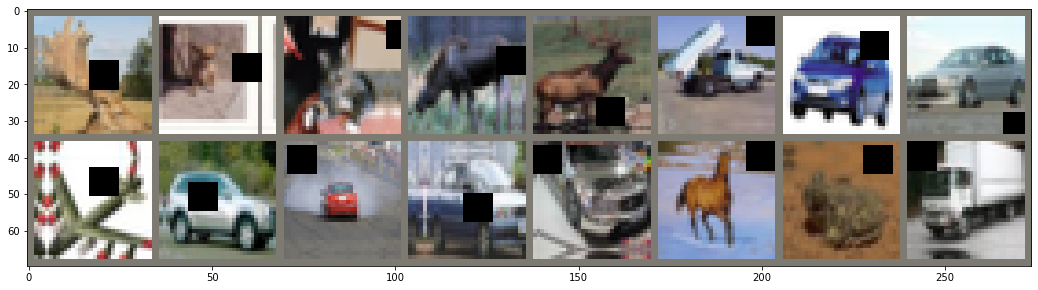

In [14]:
# V2
data_tr_Alb = iter(train_dl_Alb) 
images_tr_Alb = data_tr_Alb.next()

#Show images
show_imgBatch(torchvision.utils.make_grid(images_tr_Alb))

In [15]:
start = time.time()
for i, data in enumerate(train_dl_Alb):
    images = data
end = time.time()
time_spent = (end-start)/60
print(f"{time_spent:.3} minutes")

0.432 minutes


In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cuda')

In [18]:
train_dl_Alb = DeviceDataLoader(train_dl_Alb, device)
val_dl_Alb = DeviceDataLoader(val_dl_Alb, device)
valid_dl = DeviceDataLoader(valid_dl, device)
train_dl = DeviceDataLoader(train_dl, device)

print("len(train_dl_Alb.dataset): ", len(train_dl_Alb))
print("len(val_dl_Alb.dataset): ", len(val_dl_Alb))
print("len(valid_dl.dataset): ", len(valid_dl))

len(train_dl_Alb.dataset):  3125
len(val_dl_Alb.dataset):  625
len(valid_dl.dataset):  625


In [19]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x 

In [20]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images in train_dl_Alb:
#  for batch_idx, sample in enumerate(train_dl_Alb):
#    image, label = data['image'].cuda(), data['label'].cuda()
    images = to_device(images, device) #images.to(device) #, label.cuda()
    out = simple_resnet(images)
    print("out.shape: ", out.shape)
    break
    
for images, labels in train_dl:
#  for batch_idx, sample in enumerate(train_dl_Alb):
    #images, labels = data['image'].cuda(), data['label'].cuda()
    images, labels = to_device(images, device), to_device(labels, device)
    out = simple_resnet(images)
    print("out.shape train_dl: ", out.shape)
    break
    
del simple_resnet, images #, label
torch.cuda.empty_cache()

out.shape:  torch.Size([16, 3, 32, 32])
out.shape train_dl:  torch.Size([16, 3, 32, 32])


In [21]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

#dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
class ImageClassificationBase(nn.Module):
    def training_step(self, batch, batch_old):
        images = batch
        images_old, labels = batch_old
        images = to_device(images, device)
        out = self(images)                  # Generate predictions
        #labels = labels_g
        #print("labels: ", labels)
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        #print("type(batch): ", type(batch))
        #print("batch.shape: ", np.asarray(batch).shape)
        #print("batch: ", batch)
        
#         imgDataIter = iter(batch)
#         images = imgDataIter.__next__()
        
        #idx, images = batch
        
#         for idx, images in enumerate(batch):
#             print("image.shape ", image.shape)#, "            label: ", label)
        
        images, labels = batch
        labels_g = labels
        #print("labels valid: ", labels)
        images = to_device(images, device)
        #print("type(images): ", type(images))
        #print("images.shape: ", images.shape)
        #print("images: ", images)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [22]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [23]:
a = torch.cuda.memory_allocated(0)
print("torch.cuda.memory_allocated: ", a)
c = torch.cuda.memory_reserved(0)
print("torch.cuda.memory_reserved: ", c)

torch.cuda.memory_allocated:  788992
torch.cuda.memory_reserved:  2097152


In [24]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [25]:
@torch.no_grad()
#export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:128
    
def evaluate(model, val_loader):
    model = to_device(model, device)
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(train_loader_old, epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch, batch_old in zip(train_loader, train_loader_old):
            loss = model.training_step(batch, batch_old)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [26]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.3027193546295166, 'val_acc': 0.10509999841451645}]

In [61]:
epochs = 64
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [62]:
%%time
history += fit_one_cycle(train_dl, epochs, max_lr, model, train_dl_Alb, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00046, train_loss: 0.6527, val_loss: 6.7837, val_acc: 0.1000
Epoch [1], last_lr: 0.00065, train_loss: 0.5903, val_loss: 11.7608, val_acc: 0.1000
Epoch [2], last_lr: 0.00097, train_loss: 0.4894, val_loss: 12.2180, val_acc: 0.1000
Epoch [3], last_lr: 0.00139, train_loss: 0.4100, val_loss: 12.6518, val_acc: 0.1000
Epoch [4], last_lr: 0.00192, train_loss: 0.4253, val_loss: 16.6138, val_acc: 0.1000
Epoch [5], last_lr: 0.00253, train_loss: 0.4029, val_loss: 15.5011, val_acc: 0.1000
Epoch [6], last_lr: 0.00322, train_loss: 0.3435, val_loss: 15.2782, val_acc: 0.1000
Epoch [7], last_lr: 0.00396, train_loss: 0.3481, val_loss: 17.1790, val_acc: 0.1000
Epoch [8], last_lr: 0.00473, train_loss: 0.2993, val_loss: 17.3332, val_acc: 0.1000
Epoch [9], last_lr: 0.00551, train_loss: 0.2459, val_loss: 20.6418, val_acc: 0.1000
Epoch [10], last_lr: 0.00629, train_loss: 0.2378, val_loss: 18.9230, val_acc: 0.1000
Epoch [11], last_lr: 0.00704, train_loss: 0.2467, val_loss: 17.7369, val_acc

In [63]:
train_time='4:24'

In [64]:
accuracies_g = []
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    accuracies_g.append(accuracies)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

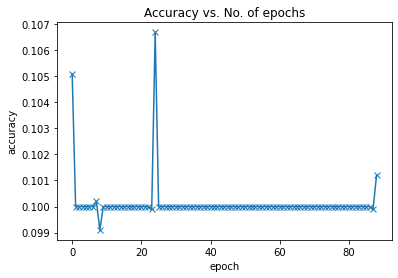

In [65]:
plot_accuracies(history)

In [66]:
print("accuracies_g: ", accuracies_g)

accuracies_g:  [[0.10509999841451645, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10019999742507935, 0.09910000115633011, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.09989999979734421, 0.10670000314712524, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.100000001490116

In [67]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

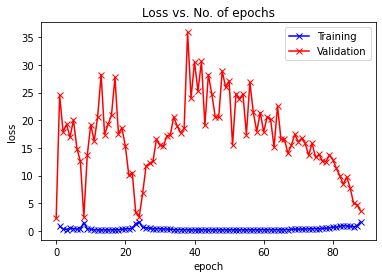

In [68]:
plot_losses(history)

In [69]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

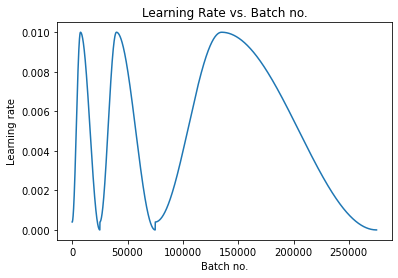

In [70]:
plot_lrs(history)

In [71]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: airplane , Predicted: frog


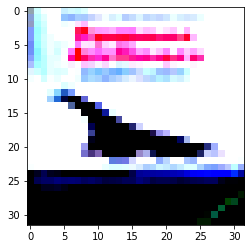

In [72]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: automobile , Predicted: frog


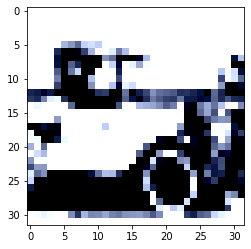

In [73]:
img, label = valid_ds[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: frog , Predicted: frog


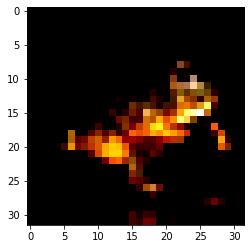

In [74]:
img, label = valid_ds[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

In [40]:
history = [evaluate(model, val_dl_Alb)]
history

ValueError: too many values to unpack (expected 2)